# Various supplement analysis and data checks

In [1]:
import numpy as np
import pandas as pd
import pickle
import functions as mf  # my functions
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error, r2_score
import nibabel as nib


## critical variables
# parcellation
PARC = 'cabn'

# subjects
subj_df = pd.read_csv('subject_list.txt', sep='\t', index_col = 0, header = 0)

# out directories
results_dir = '/projects/f_mc1689_1/ClinicalActFlow/data/results/N=93/'
figure_dir = '/projects/f_mc1689_1/ClinicalActFlow/docs/figures/N=93/'

# which connectivity type to use
fc_task = 'multitask-no-scap'
fc_method = 'pc_multregconn_100'

# task to analyze
task = 'scap'

# groups to analyze
groups = ['CTRL','SCHZ']

PAL = sns.xkcd_palette(['grey','orange'])
PAL2 = sns.xkcd_palette(['black','pale purple'])
net_PAL = sns.color_palette(['royalblue','slateblue','paleturquoise','darkorchid','limegreen',
                          'lightseagreen','yellow','orchid','r','peru','orange','olivedrab'])

# Load data

## Activity

In [2]:
# activity,activity_all = mf.load_activity(subj_df,PARC=PARC,TASKS=[task])
activity,activity_all = mf.load_activity(subj_df,PARC=PARC,TASKS=[task])
network_order,_,network_def,networks = mf.get_network_info(PARC,subcortical_split=False)
n_roi = activity['scap']['CTRL'].shape[0]

Task| scap Data loaded: 100.0 %


In [3]:
network_label = []
for i in range(len(network_def)):
    network_label.append(networks[int(network_def[i]-1)])

## Activity flow

In [4]:
# whether to run or load
do_actflow = 0

# generate activity flow predictions seperately in each group
task = 'scap'
af_file = 'actflow-' + fc_task + '-' + fc_method + '.pickle'

if do_actflow:
    predicted_activity = {}
    predicted_activity[task] = {}
    actFlowWeights = {}
    actFlowWeights[task] = {}

    for group in ['CTRL','SCHZ']:
        print('Running act flow in',group)
        fc_data = fc[fc_task][group].copy()

        actPredVector = np.zeros((np.shape(activity[task][group])))
        n_nodes =  np.shape(actPredVector)[0]
        n_conditions = np.shape(actPredVector)[1]
        n_subs = np.shape(actPredVector)[2]
        act_weights_mat = np.zeros((n_nodes,n_nodes,n_conditions,n_subs))

        for condition in range(n_conditions):
            act_data = activity[task][group][:,condition,:].copy()

            for subj in range(np.shape(fc_data)[2]):
                actPredVector[:,condition,subj],act_weights_mat[:,:,condition,subj] = mf.actflowcalc_hold_out_roi(act_data[:,subj],fc_data[:,:,subj],held_out_roi=roi_list)

        predicted_activity[task][group] = actPredVector
        actFlowWeights[task][group] = act_weights_mat
    
    print('\tsaving actflow results')
    with open(results_dir + af_file, 'wb') as handle:
        pickle.dump([predicted_activity,actFlowWeights], handle, protocol=pickle.HIGHEST_PROTOCOL)
else:
    print('\tloading actflow results')
    with open(results_dir + af_file, 'rb') as handle:
        _tmp = pickle.load(handle)
    predicted_activity = _tmp[0]
    actFlowWeights = _tmp[1]
print('Actflow finished')

	loading actflow results
Actflow finished


# Inspect group level residuals

In [5]:
plot_df = pd.DataFrame()
for group in ['CTRL','SCHZ']:
    # do the same contrast
    real = np.mean(np.mean(activity['scap'][group][:,6:12,:],axis=1),axis=1) - np.mean(np.mean(activity['scap'][group][:,0:6,:],axis=1),axis=1)
    pred = np.mean(np.mean(predicted_activity['scap'][group][:,6:12,:],axis=1),axis=1) - np.mean(np.mean(predicted_activity['scap'][group][:,0:6,:],axis=1),axis=1)

    reg_model = sm.OLS(real,sm.add_constant(pred)).fit()
    residuals = reg_model.resid.copy()

    _df = pd.DataFrame()
    _df['Real'] = real
    _df['Residuals'] = residuals
    _df['Predicted'] = pred
    _df['Network'] = network_label
    _df['Cohort'] = group
    plot_df = pd.concat([plot_df,_df])
    
# all data
real = np.hstack((np.mean(activity['scap']['CTRL'][:,6:12,:],axis=1) - np.mean(activity['scap']['CTRL'][:,0:6,:],axis=1),
               np.mean(activity['scap']['SCHZ'][:,6:12,:],axis=1) - np.mean(activity['scap']['SCHZ'][:,0:6,:],axis=1)))

pred = np.hstack((np.mean(predicted_activity['scap']['CTRL'][:,6:12,:],axis=1) - np.mean(predicted_activity['scap']['CTRL'][:,0:6,:],axis=1),
               np.mean(predicted_activity['scap']['SCHZ'][:,6:12,:],axis=1) - np.mean(predicted_activity['scap']['SCHZ'][:,0:6,:],axis=1)))
               
real = np.mean(real,axis=1)
pred = np.mean(pred,axis=1)

reg_model = sm.OLS(real,sm.add_constant(pred)).fit()
residuals = reg_model.resid.copy()

_df = pd.DataFrame()
_df['Real'] = real
_df['Residuals'] = residuals
_df['Predicted'] = pred
_df['Network'] = network_label
_df['Cohort'] = 'All'
plot_df = pd.concat([plot_df,_df])

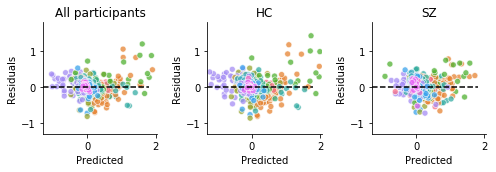

In [6]:
plt.figure(figsize=(7,2.5))

lims = ((-1.3,2.05),(-1.3,1.8))

plt.subplot(1,3,1)
sns.scatterplot(data=plot_df[plot_df['Cohort']=='All'],x='Predicted',y='Residuals',hue='Network',legend=False,alpha=0.75)
plt.title('All participants')
plt.xlim(lims[0])
plt.ylim(lims[1])
sns.despine()
plt.plot(lims[1],(0,0),'k--')

plt.subplot(1,3,2)
sns.scatterplot(data=plot_df[plot_df['Cohort']=='CTRL'],x='Predicted',y='Residuals',hue='Network',legend=False,alpha=0.75)
plt.title('HC')
plt.xlim(lims[0])
plt.ylim(lims[1])
sns.despine()
plt.plot(lims[1],(0,0),'k--')

plt.subplot(1,3,3)
sns.scatterplot(data=plot_df[plot_df['Cohort']=='SCHZ'],x='Predicted',y='Residuals',hue='Network',legend=False,alpha=0.75)
plt.title('SZ')
plt.xlim(lims[0])
plt.ylim(lims[1])
sns.despine()
plt.plot(lims[1],(0,0),'k--')

plt.tight_layout()
plt.savefig(figure_dir+'reviewer_residuals.svg')
plt.show()

# Visualize subject level prediction errors

In [7]:
plot_df = pd.DataFrame(columns=['Participant','Group','r','MAE','R2'])
resid_df = pd.DataFrame()

subj_count = 0
for group in ['CTRL','SCHZ']:
    # loop through subjects
    for subj in range(activity['scap'][group].shape[2]):
        # do the same contrast
        real = np.mean(activity['scap'][group][:,6:12,subj],axis=1) - np.mean(activity['scap'][group][:,0:6,subj],axis=1)
        pred = np.mean(predicted_activity['scap'][group][:,6:12,subj],axis=1) - np.mean(predicted_activity['scap'][group][:,0:6,subj],axis=1)
        
        r = np.corrcoef(real,pred)[0,1]
        MAE = mean_absolute_error(real,pred)
        R2 = r2_score(real,pred)
        
        plot_df = plot_df.append({'Participant': subj_count,
                                  'Group': group,
                                  'r': r,
                                  'MAE': MAE,
                                  'R2': R2,}, ignore_index=True)
        # all residuals
        reg_model = sm.OLS(real,sm.add_constant(pred)).fit()
        residuals = reg_model.resid.copy()
        _df = pd.DataFrame()
        _df['residuals'] = residuals
        _df['Network'] = network_label
        _df['Brain region'] = range(1,719)
        _df['Participant'] = subj_count
        _df['Group'] = group
        resid_df = pd.concat([resid_df,_df])
        subj_count = subj_count + 1

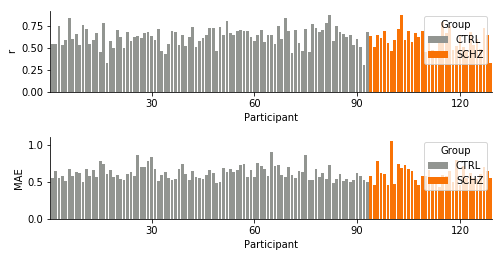

In [8]:

plt.figure(figsize=(7,5))

plt.subplot(3,1,1)
sns.barplot(y='r',x='Participant',data=plot_df,hue='Group',palette=PAL,saturation=1, dodge=False)
sns.despine()
plt.xticks(np.arange(29,130,30),labels=np.arange(30,131,30))

plt.subplot(3,1,2)
sns.barplot(y='MAE',x='Participant',data=plot_df,hue='Group',palette=PAL,saturation=1, dodge=False)
plt.xticks(np.arange(29,130,30),labels=np.arange(30,131,30))
sns.despine()

plt.tight_layout()
plt.savefig(figure_dir+'reviewer_subj_error.svg')
plt.show()

# Visualize ROI level prediction errors

In [9]:
plot_df = pd.DataFrame(columns=['Brain region','Anat','Network','r','MAE','R2'])

# all data
all_activity = np.hstack((np.mean(activity['scap']['CTRL'][:,6:12,:],axis=1) - np.mean(activity['scap']['CTRL'][:,0:6,:],axis=1),
               np.mean(activity['scap']['SCHZ'][:,6:12,:],axis=1) - np.mean(activity['scap']['SCHZ'][:,0:6,:],axis=1)))

all_predicted_activity = np.hstack((np.mean(predicted_activity['scap']['CTRL'][:,6:12,:],axis=1) - np.mean(predicted_activity['scap']['CTRL'][:,0:6,:],axis=1),
               np.mean(predicted_activity['scap']['SCHZ'][:,6:12,:],axis=1) - np.mean(predicted_activity['scap']['SCHZ'][:,0:6,:],axis=1)))

# loop through rois instead of subjects
# calculating accuracy for each ROI
for roi in range(all_activity.shape[0]):
    real = all_activity[roi,:]
    pred = all_predicted_activity[roi,:]
    
    r = np.corrcoef(real,pred)[0,1]
    MAE = mean_absolute_error(real,pred)
    R2 = r2_score(real,pred)

    if roi < 360:
        anat = 'Cortical'
    else:
        anat = 'Subcortical'

    plot_df = plot_df.append({'Brain region': roi,
                              'Anat': anat,
                              'Network': network_label[roi],
                              'r': r,
                              'MAE': MAE,
                              'R2': R2,}, ignore_index=True)

In [10]:
def wb_brain_plots(data,titles=None,inflation='very',figsize=(15,7.5)):
    plt.figure(figsize=figsize)
    
    for i in range(np.shape(data)[1]):
        mf.map_to_surface(data[:,i],'image',fliphemispheres=False)
        filename = '/projects/f_mc1689_1/ClinicalActFlow/docs/scripts/image.dscalar.nii'
        mf.print_wb_scene(filename,'image',inflation=inflation)

        plt.subplot(1,data.shape[1],i+1)
        img=mpimg.imread('image.png')
        imgplot = plt.imshow(img)
        mf.remove_border(left=False,bottom=False)
        if titles is not None:
            plt.title(titles[i],fontsize=16)
    plt.tight_layout()
    plt.show()

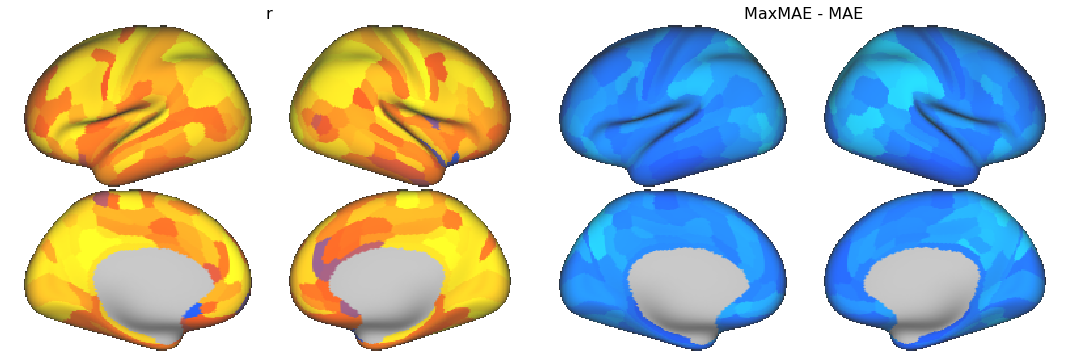

In [12]:
data = np.zeros((718,2))
data[:,0] = plot_df.r.values
data[:,1] = plot_df.MAE.values*-1

wb_brain_plots(data,titles = ['r','MaxMAE - MAE'])

#save dscalar files out (slow)
mf.map_to_surface(plot_df.r.values,figure_dir+'reviewer_r_map')
mf.map_to_surface(plot_df.MAE.values,figure_dir+'reviewer_MAE_map')
mf.map_to_surface(plot_df.MAE.values*-1,figure_dir+'reviewer_negMAE_map')

# Show that error is associated with cortical hierarchy (replicate Taku's work)
## Get Taku's myelin data

In [13]:
nParcels = 360
hierarchy_dir = '/projects/f_mc1689_1/ClinicalActFlow/data/hierarchydata/'

#get glasser
glasserfile2 = hierarchy_dir + 'Q1-Q6_RelatedParcellation210.LR.CorticalAreas_dil_Colors.32k_fs_RL.dlabel.nii'
glasser2 = nib.load(glasserfile2).get_data()
glasser2 = np.squeeze(glasser2)

#get myelin 
myelinmap = np.squeeze(nib.load(hierarchy_dir + 'Mean.339.MyelinMap_BC_MSMAll.32k_fs_LR.dscalar.nii').get_data())
nvertices = int(glasser2.shape[0]/2)

glasser_lr = np.hstack((glasser2[nvertices:],glasser2[:nvertices])) # need to flip this original parcellation

myelinmap_parc = np.zeros((nParcels,))
for roi in range(nParcels):
    roi_ind = np.where(glasser_lr==roi+1)[0]
    myelinmap_parc[roi] = np.mean(myelinmap[roi_ind])
    
# load timescale data
timescales = np.loadtxt(hierarchy_dir + 'Murray_taus_regions_autocorrelation_rest100.txt',delimiter=',')
bad_ind = np.where(timescales>50)
timescales[bad_ind] = np.nan
timescales = np.nanmean(timescales,axis=1)

# add these to the df
data = np.zeros((718))
data[0:360] = myelinmap_parc.copy()
plot_df['Myelin density (T1w/T2w)'] = data

data = np.zeros((718))
data[0:360] = timescales.copy()
plot_df['Intrinsic timescale (t)'] = data

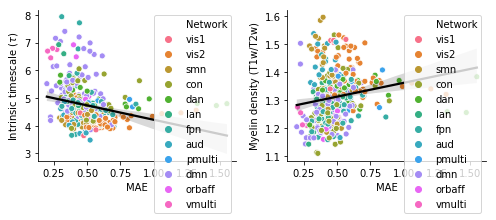

Correlations=
	Timescales: -0.23666246867452534 5.641837500374139e-06
	Myelin: 0.17407960164001632 0.0009105449301578255


In [14]:
plt.figure(figsize=(7,3))
plt.subplot(1,2,1)
sns.scatterplot(data=plot_df[plot_df['Anat']=='Cortical'],y='Intrinsic timescale (t)',x='MAE',hue='Network')
sns.regplot(data=plot_df[plot_df['Anat']=='Cortical'],y='Intrinsic timescale (t)',x='MAE',scatter=False,fit_reg=True,color='k')
plt.ylabel(r'Intrinsic timescale ($\tau$)')
sns.despine()

plt.subplot(1,2,2)
sns.scatterplot(data=plot_df[plot_df['Anat']=='Cortical'],y='Myelin density (T1w/T2w)',x='MAE',hue='Network')
sns.regplot(data=plot_df[plot_df['Anat']=='Cortical'],y='Myelin density (T1w/T2w)',x='MAE',scatter=False,fit_reg=True,color='k')
sns.despine()

plt.tight_layout()
plt.savefig(figure_dir+'reviewer_myelin-timescales.svg')
plt.show()

print('Correlations=')
r,p = pearsonr(plot_df.MAE.values[0:360],timescales)
print('\tTimescales:',r,p)
r,p = pearsonr(plot_df.MAE.values[0:360],myelinmap_parc)
print('\tMyelin:',r,p)

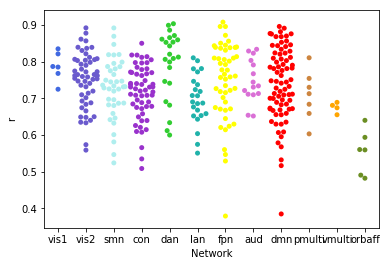

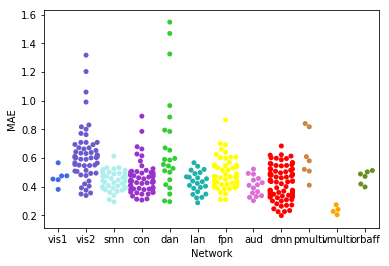

In [15]:
sns.swarmplot(data=plot_df[plot_df['Anat']=='Cortical'],y='r',x='Network',order=networks,palette=net_PAL)
plt.show()

sns.swarmplot(data=plot_df[plot_df['Anat']=='Cortical'],y='MAE',x='Network',order=networks,palette=net_PAL)
plt.show()